如果聚合一组预测器（比如分类器或回归器）的预测，得到的预测结果也比最好的单个预测器要好。这样的一组预测器，称为集成，这种技术也被称为集成学习，而一个集成学习的算法则被称为集成方法。

例如，可以训练一组决策树分类器，每一棵树都基于训练集不同的随机子集进行训练。然后可以获得所有个体树的预测，获得最多选票的类是集成的预测

这样一组决策树的集成被称为随机森林，尽管很简单，但它是迄今可用的最强大的机器学习算法之一。

此外，在项目快要结束时，可能已经构建好了一些不错的预测器，这时就可以通过集成方法，将它们组合成一个更强的预测器。

## 投票分类器

假设已经训练好了一些分类器，每个分类器的精度约为80%。大概包括：一个逻辑回归分类器、一个SVM分类器、一个随机森林分类器、一个k近邻分类器，或许还有更多

创建更好分类器的一种非常简单的方法是聚合每个分类器的预测：获得最多选票的类是集成的预测。这种多数投票分类器称为硬投票分类器

这个投票分类器的精度通常比集成中最好的分类器还要高，这个结果可能有点不符合直觉

事实上，即使每个分类器都是弱学习器（意味着它仅比随机猜测好一点），通过集成依然可以实现一个强学习器（高精度），只要有足够大数量并且足够多种类的弱学习器就可以。

假设有一个略微偏倚的硬币，它有51%的可能正面朝上，49%的可能背面花朝上。如果你掷1000次，大致会得到差不多510次正面和490次背面，所以正面是大多数。

而如果做数学题，会发现在1000次投掷后，大多数为正面朝上”的概率接近75%。投掷硬币的次数越多，这个概率越高（例如，投掷10000次后，这个概率攀升至97%）。

这是因为大数定理导致的：随着你不断投掷硬币，正面朝上的比率越来越接近于正面的概率(51%)。

下面代码生成的图显示了10枚偏倚硬币的投掷结果。可以看出随着投掷次数的增加，正面的比率逐渐接近51%，最终所有10条线全都接近51%，并且始终位于50%以上

同样，假设创建了一个包含1000个分类器的集成，每个分类器都只有51%的概率是正确的（几乎没比随机猜测强多少）。如果以大多数投票的类作为预测结果，可以期待的准确率高达75%。

但是，这基于的前提是：所有的分类器都是完全独立的，彼此的错误毫不相关。显然这是不可能的，因为它们都是在相同的数据上训练的。它们很可能会犯相同的错误，所以也会有很多次大多数投给了错误的类，导致集成的精度有所降低。

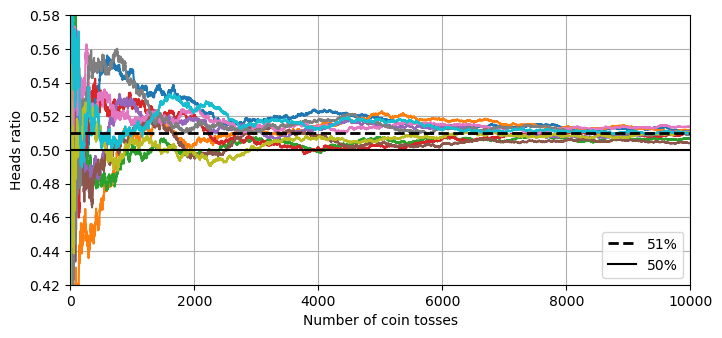

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from nltk import extract

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
plt.show()

当预测器尽可能互相独立时，集成方法的效果最优。获得多种分类器的方法之一就是使用不同的算法进行训练。这会增加它们犯不同类型错误的机会，从而提升集成的精度。

Scikit-Learn提供了一个非常易于使用的VotingClassifier类：只需给它一个名称/预测器对列表，然后像普通分类器一样使用它。

加载 月牙形数据集并将其拆分为训练集和测试集，然后创建并训练由三个不同分类器组成的投票分类器：

In [91]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', LogisticRegression(random_state=42)),
                ('rf', RandomForestClassifier(random_state=42)),
                ('svc', SVC(random_state=42))]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

当拟合VotingClassifier时，它会克隆每个估计器并拟合这个克隆。

原始估计器可通过estimators属性获得，而拟合克隆可通过 estimators_ 属性获得。

如果更喜欢字典而不是列表，则可以改用named_estimators或named_estimators_。

首先，看看每个拟合分类器在测试集上的精度：

In [3]:
voting_clf.named_estimators_
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


当调用投票分类器的predict()方法时，它会执行硬投票。

例如，投票分类器为测试集的第一个实例预测类1，因为三个分类器中有两个预测了该类：

In [4]:
voting_clf.predict(X_test[:1])                                # 直接预测是1 类
# [clf.predict(X_test[:1]) for clf in voting_clf.estimators_]  # 三个里 有两个预测了是 1类

array([1], dtype=int64)

In [5]:
# 投票分类器在测试集上的表现
voting_clf.score(X_test, y_test)  # 投票分类器优于单个分类器

0.912

In [6]:
# 随堂练习：  不用VotingClassifier，自己模拟一下创建多个估计器，然后保留所有估计器最频繁的预测（投票过程），
#     看看能否得到和 voting_clf相似的预测结果
lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
svc = SVC(random_state=42)


lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
svc.fit(X_train, y_train)



SVC(random_state=42)

In [7]:
from scipy.stats import mode

lr_pred = lr.predict(X_test)
rf_pred = rf.predict(X_test)
svc_pred = svc.predict(X_test)

all_preds = np.c_[lr_pred, rf_pred, svc_pred]
all_preds


# final_pred = (np.sum(all_preds, axis=1) >= 2).astype(int)
final_pred = mode(all_preds, axis=1).mode  # 按行求众数
#
from sklearn.metrics import accuracy_score
accuracy_score(y_test,final_pred)

0.912

In [8]:
mode(np.array([1,1,2,3,3,3,3,3])).mode

3

如果所有分类器都能够估计类概率［即如果它们都有一个predict_proba()方法］，

那么可以告诉Scikit-Learn预测具有最高类概率的类，对所有单独的分类器进行平均。这称为软投票。

它通常比硬投票能获得更高的性能，因为它给高度自信的投票更多的权重。需要做的就是将投票分类器的投票超参数设置为"soft"，并确保所有分类器都可以估计类概率。

默认情况下SVC类不是这种情况，因此需要将其probability超参数设置为True［这会使SVC类使用交叉验证来估计类概率，减慢训练速度，并且它会添加一个predict_proba()方法］。

In [9]:
voting_clf.voting
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True # 原始估计器修改属性
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)  # 软投票又提高了性能

0.92

## bagging和pasting

前面提到，获得不同种类分类器的方法之一是使用不同的训练算法。

还有另一种方法是每个预测器使用的算法相同，但是在不同的训练集随机子集上进行训练。

采样时如果将样本放回，这种方法叫作bagging(bootstrap aggregating的缩写)

采样时样本不放回，这种方法则叫pasting。

换句话说，bagging和pasting都允许训练实例在多个预测器中被多次采样，但是只有bagging允许训练实例被同一个预测器多次采样。采样过程和训练过程如图所示：

![在训练集的不同随机样本上训练几个预测其](./images/random_forest/p1.png)

一旦预测器训练完成，集成就可以通过简单地聚合所有预测器的预测，来对新实例做出预测。

聚合函数通常是分类的统计模式（即最多数的预测就像硬投票分类器），或是平均法用于回归。

每个预测器单独的偏差都高于在原始训练集上训练的偏差，但是聚合可以同时降低偏差和方差。

总体来说，最终结果是，与直接在原始训练集上训练的单个预测器相比，集成的偏差相近，但是方差更低。

可以通过不同的CPU内核甚至是不同的服务器，并行地训练预测其。类似地，预测也可以并行。这正是bagging和pasting方法如此流行的原因之一，它们容易应用在大的训练集上。

In [10]:
# sklearn提供了一个简单的API——BaggingClassifier类——进行bagging和pasting（或BaggingRegressor用于回归

# 以下代码训练了500棵决策树分类器的集成，每次随机从训练集中采样100个训练实例进行训练，然后放回

# 如果想用pasting，只需要设置bootstrap=False即可

# n_jobs用来指示sklearn用多少CPU内核进行训练和预测，-1表示让sklearn使用所有可用内核

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

如果基本分类器可以估计类概率［如果它具有predict_proba()方法］，则BaggingClassifier自动执行软投票而不是硬投票

从下图可以看出，集成预测的泛化效果很可能会比单独的决策树要好一些：二者偏差相近，但是集成的方差更小（两边训练集上的错误数量差不多，但是集成的决策边界更规则）。



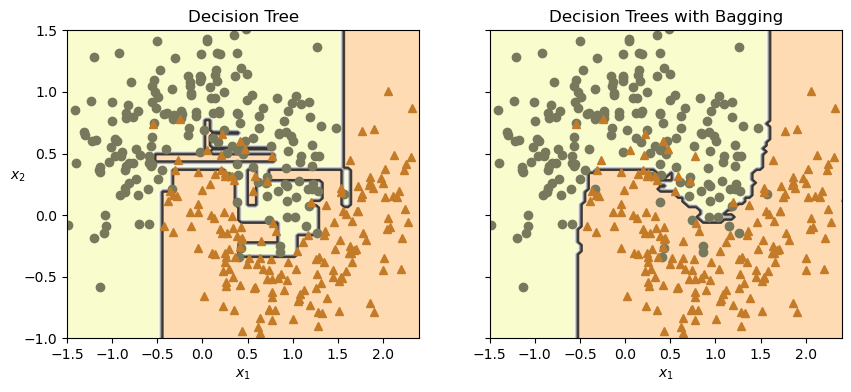

In [11]:
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()

 由于自举法给每个预测器的训练子集引入了更高的多样性，因此最后bagging比pasting的偏差略高，但这也意味着预测器之间的关联度更低，所以集成的方差降低。

总之，bagging生成的模型通常更好，所以bagging比pasting更受欢迎。

但是，如果有充足的时间和CPU资源，可以使用交叉验证来对bagging和pasting的结果进行评估，再做出最合适的选择。

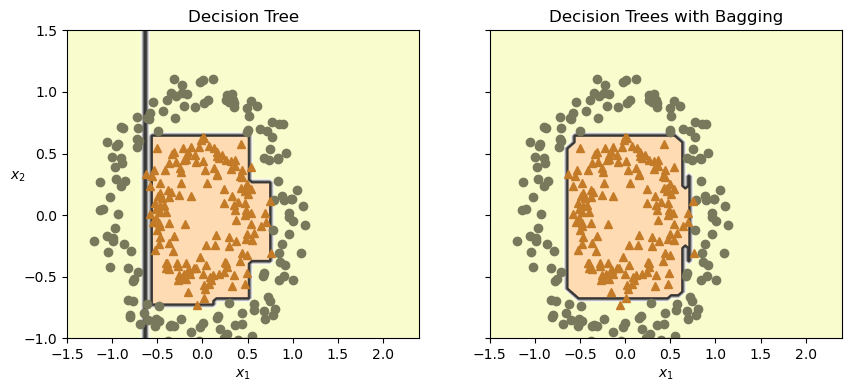

In [12]:
# 随堂练习：X, y = make_circles(n_samples=300, factor=0.5, noise=0.1, random_state=42)  生成圆的分类数据
# 练习1： 对这个数据用BaggingClassifer分类一下试试，对比单个决策树，和 放回采样训练的 多个决策树预测的决策边界的区别
from sklearn.datasets import make_circles
X_circle, y_circle = make_circles(n_samples=300, factor=0.5, noise=0.1, random_state=42)

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_circle, y_circle)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_circle, y_circle)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_circle, y_circle)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_circle, y_circle)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()



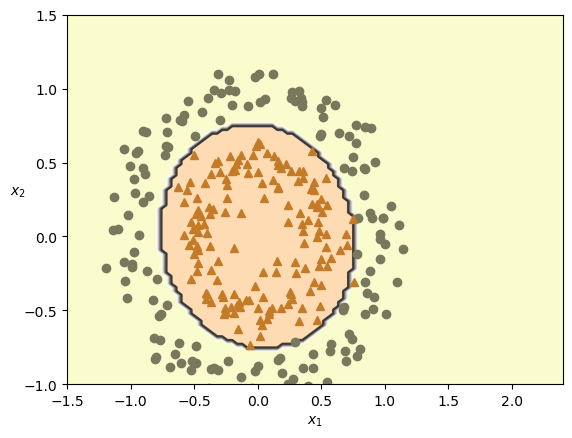

In [13]:
# 练习2： 复习：这个数据看起来很适合 用SVM。写一下SVM拟合这个数据。 画出决策边界
svc =SVC(kernel="poly", degree=2)
svc.fit(X_circle, y_circle)
plot_decision_boundary(svc, X_circle, y_circle)

### 包外评估

对于任意给定的预测器，使用bagging，有些训练实例可能会被采样多次，而有些实例则可能根本不被采样。

BaggingClassifier默认采样m个训练实例，然后放回样本(bootstrap=True)，m是训练集的大小。通过这个过程，可以从数学上表明，对每个预测器来说，平均只对63%的训练实例进行采样[。剩余37%未被采样的训练实例称为包外(Out Of Bag)实例。

注意，对所有预测器来说，这是不一样的37%。

- 展示m次有放回的采样，平均只会对63%的训练实例采样 （大一/高中的数学）

m个训练集，每个样本被选中的概率是1/m，不被选中的概率是 1-1/m;  -> m次都不被选中的概率是 (1-1/m)^m, m越大，这个概率越接近 1/e，约等于37%左右

 bagging集成可以使用OOB（Out Of Bag）实例进行评估，而不需要单独的验证集：实际上，如果有足够的估计器，那么训练集中的每个实例都可能是多个估计器的OOB实例，

因此可以使用这些估计器为该实例做出公平的集成预测。一旦对每个实例都有预测，就可以计算集成的预测精度（或任何其他指标）。

在sklearn中，创建BaggingClassifier时，设置oob_score=True，就可以请求在训练结束后自动进行包外评估。

下面的代码演示了这一点。通过变量oob_score_可以得到最终的评估分数：

In [14]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,  oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
# bag_clf.oob_score_

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True, random_state=42)

In [15]:
bag_clf.oob_score_

0.896

In [16]:
# 正式测在测试集上的精度
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

In [17]:
# 每个训练实例的OOB决策函数也可通过oob_decision_function_属性获得。
# 由于基础估计器有一个predict_proba()方法，决策函数返回每个训练实例的类概率
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

### 随机补丁和随机子空间

BaggingClassifier类也支持对特征进行采样。采样由两个超参数控制：max_features和bootstrap_features。

它们的工作方式与max_samples和bootstrap相同，但用于特征采样而不是实例采样。因此，每个预测器将用输入特征的随机子集进行训练。

当你处理高维输入（例如图像）时，此技术特别有用，因为它可以减少训练特征大大加快训练速度。

对训练实例和特征进行采样称为随机补丁方法。保留所有训练实例（通过设置bootstrap=False和max_samples=1.0）但对特征进行采样（通过将bootstrap_features设置为True或max_features为小于1.0的值）称为随机子空间方法。

对特征进行采样导致更多的预测多样性，用略高一点的偏差换取更低的方差。

## 随机森林

随机森林是决策树的集合，通常通过bagging方法（有时候pasting方法）进行训练，通常将max_samples设置为训练集的大小。

可以使用RandomForestClassifier类，而不是构建BaggingClassifier并将其传递给DecisionTreeClassifier

它更方便并且针对决策树进行了优化（类似地，有一个用于回归任务的RandomForestRegressor类）。

以下代码使用所有可用的CPU内核训练一个包含500棵树的随机森林分类器，每棵树最多有16个叶节点：

In [18]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
y_pred_rf

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], dtype=int64)

RandomForestClassifier具有DecisionTreeClassifier的所有超参数（以控制树的生长方式），以及BaggingClassifier的所有超参数来控制集成本身。

随机森林算法在树的生长上引入了更多的随机性：拆分节点时不再搜索最好的特征，而是在一个随机生成的特征子集里搜索最好的特征。

默认情况下，才采样sqrt(n)个特征（n是特征的总个数）。

导致决策树具有更大的多样性，用更高的偏差换取更低的方差，总之，还是产生了一个整体性能更优的模型。

下面的BaggingClassifier与前面的RandomForestClassifier相同：

In [19]:
# 随堂练习： 根据刚才对原理的描述，通过BaggingClassifier 和 决策树， 生成和前面相同的RandomForestClassifier
bag_clf2 = BaggingClassifier(DecisionTreeClassifier(max_leaf_nodes=16, max_features="sqrt"), n_estimators=500,  n_jobs=-1, random_state=42)
bag_clf2.fit(X_train, y_train)
y_pred_rf2 = bag_clf2.predict(X_test)

print(np.all(y_pred_rf2 == y_pred_rf))

True


### 极端随机树

随机森林里单棵树的生长过程中，每个节点在拆分时仅考虑了一个随机子集所包含的特征。

如果我们对每个特征使用随机阈值，而不是搜索得出的最佳阈值（如常规决策树所做的），则可能让决策树生长得更加随机

只需在创建DecisionTreeClassifier时设置splitter="random"。

这种极端随机的决策树组成的森林，被称为极端随机树集成。同样，它也是以更高的偏差换取了更低的方差。

极端随机树训练起来比常规随机森林要快很多，因为在每个节点上找到每个特征的最佳阈值是决策树生长中最耗时的任务之一。

可以使用Scikit-Learn的ExtraTreesClassifier类。它的API与RandomForest-Classifier类相同，除了bootstrap默认为False。同样，ExtraTreesRegressor类具有与RandomForestRegressor类相同的API，除了bootstrap默认为False。

通常来说，不一定预先知道一个RandomForestClassifier是否会比一个ExtraTreesClassifier更好或是更差。唯一的方法是两种都尝试一遍，然后使用交叉验证进行比较。

In [20]:
# 随堂练习：尝试使用ExtraTreesClassifier, 训练后在测试集上评估性能
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(n_estimators=500, n_jobs=-1, random_state=42, max_leaf_nodes=16)
etc.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, etc.predict(X_test))

# accuracy_score(y_test, rnd_clf.predict(X_test))

0.912

### 特征重要性

随机森林的另一个好特性是，它们使测量每个特征的相对重要性变得容易。

sklearn通过查看使用该特征的树节点平均（在森林中的所有树上）减少杂质的程度来衡量该特征的重要性。

更准确地说，它是一个加权平均值，其中每个节点的权重等于与其关联的训练样本的数量

在 **RandomForestClassifier**里特征重要性是通过 **平均减少杂质**（Mean Decrease in Impurity, MDI）来衡量的。

核心思想：

* 如果一个特征在分裂数据时，能显著减少节点的不纯度（impurity），那么它对模型预测的贡献就越大。
* 计算时会考虑 **该分裂节点覆盖的样本数**，因为分裂一个样本数很多的节点影响更大。

计算步骤：

1. **计算节点的不纯度（Impurity）**
   常用 Gini 指数或熵：

   * **Gini**（二分类）：

     $$
     G(t) = 1 - p_0^2 - p_1^2
     $$

     其中 $p_k$ 是节点中类别 $k$ 的比例。
   * **熵**（Entropy）：

     $$
     H(t) = - \sum_k p_k \log_2 p_k
     $$

2. **计算该节点分裂带来的杂质减少量（Impurity Decrease）**
   对于节点 $t$，设：

   * $N_t$：到达节点 $t$ 的样本数
   * $I(t)$：该节点的不纯度
   * 左子节点 $t_L$ 样本数 $N_L$，不纯度 $I(t_L)$
   * 右子节点 $t_R$ 样本数 $N_R$，不纯度 $I(t_R)$
     那么：

   $$
   \Delta I_t = I(t) - \frac{N_L}{N_t} I(t_L) - \frac{N_R}{N_t} I(t_R)
   $$

3. **加权节点的重要性贡献**
   sklearn 会用 **样本数权重**来放大重要性：

   $$
   \text{contribution}_t = N_t \times \Delta I_t
   $$

   这样一个大节点的分裂（即使 impurity decrease 不算特别大）也能体现出它的重要性。

4. **汇总每个特征的贡献**
   对森林中所有树的所有节点，凡是用特征 $j$ 分裂的，累计它们的 contribution：

   $$
   \text{score}_j = \sum_{\text{nodes split on } j} N_t \times \Delta I_t
   $$

5. **归一化**
   把所有特征的 score 相加得到总和 $S$，然后：

   $$
   \text{importance}_j = \frac{\text{score}_j}{S}
   $$

   这样所有特征的重要性之和等于 1。

Scikit-Learn会在训练后为每个特征自动计算该分数，然后对结果进行缩放以使所有重要性的总和等于1。

可以使用feature_importances_变量来访问结果。例如，以下代码在鸢尾花数据集上训练了RandomForestClassifier，并输出每个特征的重要性。看起来最重要的特征是花瓣长度(44%)和宽度(42%)，而花萼的长度和宽度则相对不那么重要（分别是11%和2%)

In [21]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)

rnd_clf.feature_importances_
np.sum(rnd_clf.feature_importances_)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


In [22]:
list(zip(rnd_clf.feature_names_in_, rnd_clf.feature_importances_))

[('sepal length (cm)', 0.11249225099876375),
 ('sepal width (cm)', 0.02311928828251033),
 ('petal length (cm)', 0.4410304643639577),
 ('petal width (cm)', 0.4233579963547682)]

同样，如果在MNIST数据集上训练随机森林分类器，并绘制每个像素的重要性。

In [23]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

X_mnist.shape  # 70000 * 784(28*28)
y_mnist # 70000,  (具体的数字）


array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [24]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

RandomForestClassifier(random_state=42)

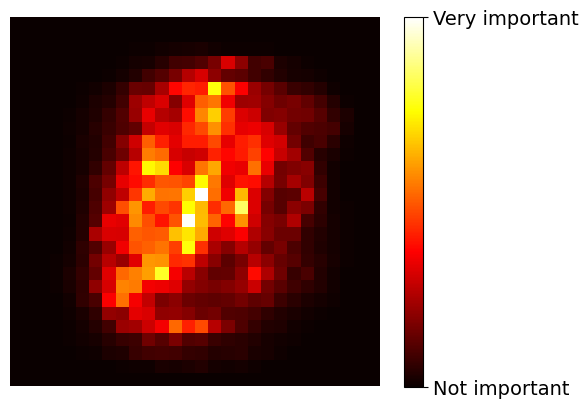

In [26]:
heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
plt.show()



## 提升法

提升法（boosting)是指可以将几个弱学习器结合成一个强学习器的任意集成方法。

大多数提升法的总体思路是循环训练预测器，每一次都对其前序做出一些改成。

### AdaBoost

新预测器对其前序进行纠正的办法之一，就是更多地关注前序欠拟合的训练实例。从而使新的预测器不断地越来越专注于难缠的问题，这就是AdaBoost使用的技术。

例如，当训练AdaBoost分类器时，该算法首先训练一个基础分类器（例如决策树），并使用它对训练集进行预测。然后，该算法会增加分类错误的训练实例的相对权重。之后，它使用更新后的权重训练第二个分类器，并再次对训练集进行预测，更新实例权重，以此类推

第一个分类器产生了许多错误实例，所以这些实例的权重得到提升。因此第二个分类器在这些实例上的表现有所提升，然后第三个、第四个……右图绘制的是相同预测器序列，唯一的差别在于学习率减半（即错误分类的实例权重在每次迭代中提升得更少）​。可以看出，AdaBoost这种依序循环的学习技术跟梯度下降有一些异曲同工之处，差别只在于——不再是调整单个预测器的参数使代价函数最小化，而是不断在集成中加入预测器，使模型越来越好。

在make_moon数据集上5个连续的预测器的决策边界（在本例中，每个预测器都是使用RBF内核函数的高度正则化的SVM分类器， 注意SVM只是用来举例，一般AdaBoost不会配合SVM使用）。

一旦全部预测器训练完成，集成整体做出预测时就跟bagging或pasting方法一样了，除非预测器有不同的权重，因为它们总的精度基于加权后的预测器的预测。

这种依序学习技术有一个重要的缺点：训练不能并行化，因为每个预测器只能在前一个预测器被训练和评估后才能被训练。因此，在扩展方面，它的表现不如bagging和pasting方法。

 仔细看看 AdaBoost 算法。每个实例权重 $w^{(i)}$ 最初设置为 $1/m$。对第一个预测器进行训练，并根据训练集计算其加权误差率 $r_1$，见以下公式 1。

关注：1. 样本权重如何更新的？   2. 预测器的权重怎么来的？

**公式 1：第 $j$ 个预测器的加权误差率**

$$
r_j = \sum_{i=1}^m w^{(i)} \cdot \mathbf{1}\left( \hat{y}_j^{(i)} \neq y^{(i)} \right)
$$

其中，$\hat{y}_j^{(i)}$ 是第 $i$ 个实例的第 $j$ 个预测器的预测。

预测器的权重 $\alpha_j$ 通过公式 2 来计算，其中 $\eta$ 是学习率超参数（默认为 1）$\eta$。
预测器的准确率越高，其权重就越高。如果它只是随机猜测，则其权重接近于零。
但是，如果在大部分情况下它都是错的（也就是精度比随机猜测还低），那么它的权重为负。

**公式 2：预测器权重**

$$
\alpha_j = \eta \log \frac{1 - r_j}{r_j}
$$

接下来，AdaBoost 算法使用公式 3 更新实例权重，从而提高了误分类实例的权重。

**公式 3：权重更新规则**

对于 $i = 1, 2, \ldots, m$

$$
w^{(i)} \leftarrow
\begin{cases}
w^{(i)}, & \hat{y}_j^{(i)} = y^{(i)} \\
w^{(i)} \exp(\alpha_j), & \hat{y}_j^{(i)} \neq y^{(i)}
\end{cases}
$$

然后对所有实例权重进行归一化（即除以 $\sum w^{(i)}$）。

最后，使用更新后的权重训练一个新的预测器，然后重复整个过程
（计算新预测器的权重，更新实例权重，然后对另一个预测器进行训练，等等）。
当到达所需数量的预测器或得到完美的预测器时，算法停止。

预测时，AdaBoost 通过计算所有预测器的预测结果，并使用预测器权重 $\alpha$ 对它们进行加权。
最后，得到多数加权投票的类别就是预测器给出的预测类别（见公式 4）。

**公式 4：AdaBoost 预测**

$$
\hat{y}(x) = \arg\max_k \sum_{j=1}^N \alpha_j \cdot \mathbf{1}\left( \hat{y}_j(x) = k \right)
$$

其中 $N$ 是预测器的数量。



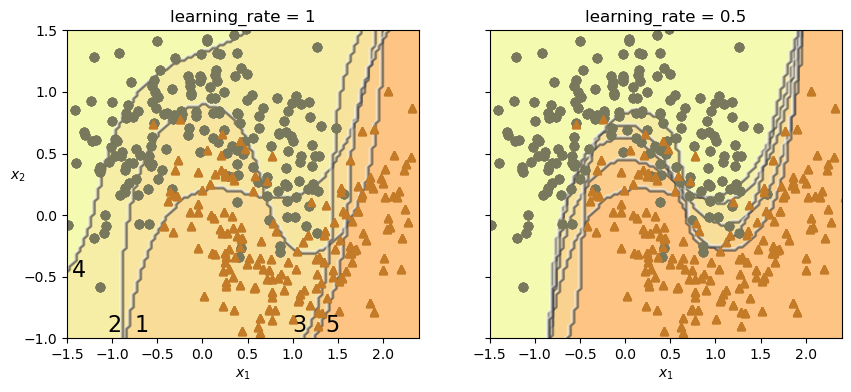

In [92]:
m = len(X_train)


fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m  # [1/m, 1/m, .... 1/m]
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)   # 通过指定权重，强调出错的实例
        y_pred = svm_clf.predict(X_train)

         # 公式1
        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # 第i个预测器的错误率

        # 公式2
        alpha = learning_rate * np.log((1 - r) / r)  # 第i个预测器的权重

        # 公式3
        sample_weights[y_pred != y_train] *= np.exp(alpha)

        sample_weights /= sample_weights.sum()  # 归一化

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

plt.show()

In [112]:
# 随堂练习：基于刚才的训练结果 去集成预测一下训练集里的数据 样本的分类
learning_rate = 1
models = []
alphas = []
sample_weights = np.ones(m) / m  # [1/m, 1/m, .... 1/m]

for i in range(5):
    svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
    svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)   # 通过指定权重，强调出错的实例
    y_pred = svm_clf.predict(X_train)
    models.append(svm_clf)

     # 公式1
    error_weights = sample_weights[y_pred != y_train].sum()
    r = error_weights / sample_weights.sum()  # 第i个预测器的错误率

    # 公式2
    alpha = learning_rate * np.log((1 - r) / r)  # 第i个预测器的权重
    alphas.append(alpha)

    # 公式3
    sample_weights[y_pred != y_train] *= np.exp(alpha)

    sample_weights /= sample_weights.sum()  # 归一化

In [126]:
final_predictions_train = sum([np.where(model.predict(X_train) == np.array([0,1]).reshape(-1,1), w, 0)  for model, w in zip(models, alphas)]).argmax(axis=0)  # 找出加权投票最大的分类： 一行代码
accuracy_score(y_train, final_predictions_train)

0.8906666666666667

In [18]:
# 使用30个 max_depth=1的决策树 （单个决策节点 和 两个叶节点组成的树）作为 基模型的AdaBoostClassifier类

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=30, learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

# 如果AdaBoost集成过拟合训练集，可以试试减少估计器的数量，或提高下基础估计器的正则化程度


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

In [19]:
ada_clf.score(X_train, y_train)
ada_clf.score(X_test, y_test)

0.904

- 注意：AdaBoost也有自己的回归版本：AdaBoostRegressor，和分类去变大分类错误的实例的权重不同，回归去变大平方误差大的实例的权重

- Scikit-learn使用的是AdaBoost的一个多分类版本（AdaBoost明显针对二分类），叫作SAMME（基于多类指数损失的逐步添加模型），这些boost算法最开始也是有损失函数的，它们的算法步骤是靠最小化损失函数推导过来的，具体的推导过程涉及对自变量是函数的函数求导（泛函分析），感兴趣的可以参考SAMME算法的原始论文：https://hastie.su.domains/Papers/samme.pdf

- 如果预测器可以估算类概率（具有predict_proba()方法），Scikit-Learn会使用一种SAMME的变体，称为SAMME.R，它依赖的是类概率而不是类预测，通常表现会更好

### 梯度提升
另一个提升法是梯度提升。和AdaBoost一样，梯度提升也是逐步在集成中添加预测器，每一个都对其前序做出改正。

不同之处在于，它不是像AdaBoost那样在每个迭代中调整实例权重，而是让新的预测器针对前一个的残差进行拟合。

In [20]:
# 使用决策树作为基本预测器，按残差去拟合 -> 梯度提升回归树
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x^2 + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [21]:
# 针对第一个训练器的残差，训练第二个DecisionTreeRegressor
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [22]:
# 针对第二个预测器的残差，训练第三个回归器

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [23]:
# 三棵树的集成： 第一个预测 h1， 第二个预测残差h2, 第三个预测残差h3；三个预测相加(h1+h2+h3)，对新实例进行预测
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

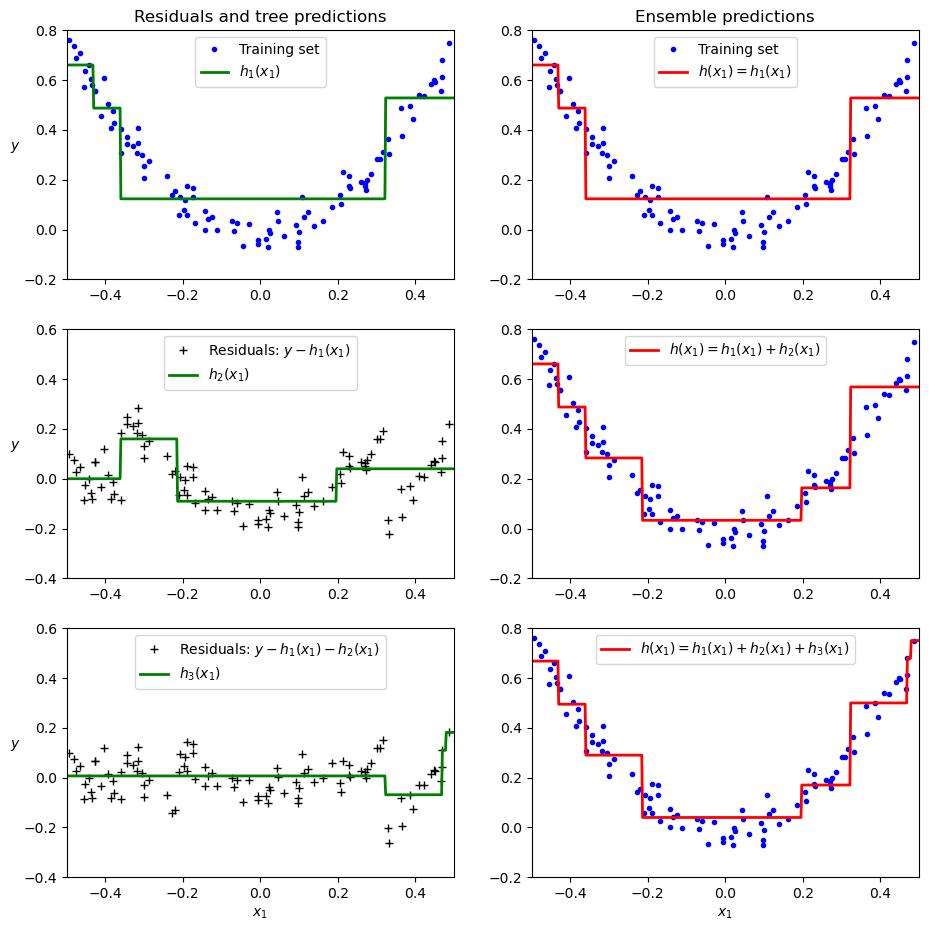

In [28]:
# 第一个预测器进行正常训练，然后对每个连续的预测器（左中和左下）针对先前预测器的残差进行训练
# 右列显示集成预测的结果

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

plt.show()

可以使用sklearn的GradientBoostingRegressor类更轻松地训练GBRT集成（还有个用于分类的GradientBoostingClassifier类）

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

# 与RandomForestRegressor类非常相似，它具有控制决策树生长的超参数（例如max_depth, min_samples_leaf),以及控制集成训练的超参数，比如树的数量（n_estimators)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)  # 这里创建的集成 和前面代码相同
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

超参数Learning-rate缩放每棵树的贡献。如果将其设置为较低的值（例如0.05），则集成中将需要更多的树来拟合训练集，但预测通常会更好地泛化。（这个正则化技术叫做收缩）

要找到树的最佳数量，可以使用GridSearchCV或RandomizedSearchCV执行交叉验证，但有更简单的方法：

- 将 n_iter_no_change 超参数设置为一个整数值，比如10，那么如果GradientBoostingRegressor 发现最后10棵树没有帮助，它将在训练期间自动停止添加更多树 -> 早停。

下面代码使用这个技巧来训练集成：

In [29]:
gbrt_best = GradientBoostingRegressor(max_depth=2, learning_rate=0.05, n_estimators=500, n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [30]:
# 如果将 n_iter_no_change 设置得太低，训练可能会早停并且模型会欠拟合。
# 但如果设置得太高，它反而会过拟合。
# 这里设置了个小的学习率 和 大量估计器，但实际估计器数量很少，归功于 n_iter_no_change （早停）
gbrt_best.n_estimators_

92

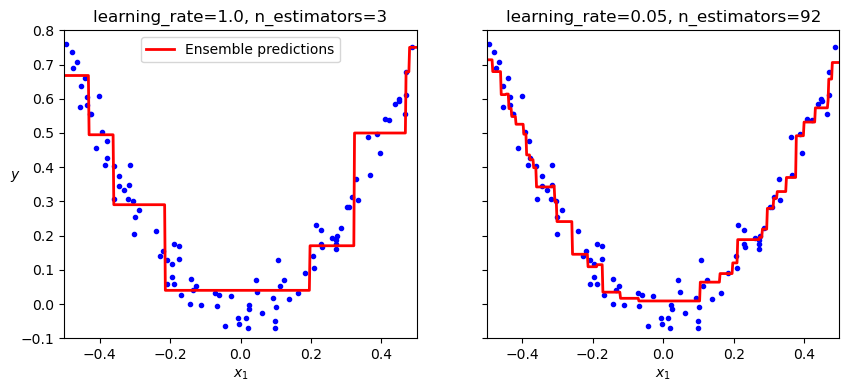

In [31]:
# GBRT 集成没有足够的预测器 vs 有足够的预测器
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

plt.show()

设置n_iter_no_change时，fit()方法会自动将训练集拆分为较小的训练集和验证集：允许在每次添加新树时评估模型的性能。

验证集的大小由validation_fraction超参数控制，默认为10%。 tol超参数确定可以忽略不计的性能改进，默认是0.0001。

GradientBoostingRegressor类还支持一个subsample超参数，指定要用于训练每个树的训练实例的比例，比如subsample=0.25，每棵树都随机选择25%的训练实例进行训练。 -> 高偏差换低方差

- 1. 梯度提升的思路  （拟合残差的理论基础，辅助理解梯度提升在做什么）

要最小化的目标是：

$$
L = \sum_i L(y_i, F(x_i))
$$

这里的“变量”不是参数 $\theta$，而是整个函数 $F(x)$。

在函数空间里做梯度下降，更新公式变成：

$$
F_m(x) = F_{m-1}(x) - \eta \, g_m(x)
$$

其中：

$$
g_m(x_i) = \left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{F = F_{m-1}}
$$

也就是说：每个样本的“梯度方向”，我们用一个弱学习器（比如决策树 $h_m(x)$）去拟合它。



- 2. 为什么是“拟合残差”

- 如果损失是平方误差：

$$
L(y, F(x)) = \frac{1}{2}(y - F(x))^2
$$

那么：

$$
g_m(x_i) = - (y_i - F_{m-1}(x_i)) = -r_i
$$

所以 **负梯度 = 残差**。

- 拟合残差的树 $h_m(x)$ 就近似了 $-g_m(x)$。

于是：

$$
F_m(x) = F_{m-1}(x) - \eta \cdot (-r_i) \Rightarrow F_m(x) = F_{m-1}(x) + \eta r_i
$$

也就是说：新预测器 = 旧预测器 + 学习率 × 拟合残差的弱学习器。



3. 总结

梯度提升的每一步就是：

- 在函数空间里做梯度下降；
- “拟合残差”就是在近似负梯度；
- 更新公式就等价于**之前的预测器 - (负梯度)**，


### 基于直方图的梯度提升

Scikit-Learn 还提供了另一种针对大型数据集优化的 GBRT 实现：基于直方图的梯度提升（Histogram-based Gradient Boosting，HGB）。它的工作原理是对输入特征进行分箱，用整数代替它们。箱的数量由 `max_bins` 超参数控制，默认为 255 并且不能设置为高于此值。分箱可以大大减少训练时需要评估的可能阈值的数量。此外，使用整数可以让我们使用更快、更节省内存的数据结构。箱的构建方式也消除了在训练每棵树时对特征进行排序的需要。

因此，此实现的计算复杂度为 $O(b \times m)$ 而不是 $O(n \times m \log(m))$，其中 $b$ 是箱的数量，$m$ 是训练实例的数量，$n$ 是特征的数量。实际上，这意味着 HGB 在大型数据集上的训练速度比常规 GBRT 快数百倍。然而，分箱会导致精度损失，它充当正则化器：根据数据集，这可能有助于减少过拟合，也可能导致欠拟合。

Scikit-Learn 为 HGB 提供了两个分类：`HistGradientBoostingRegressor` 和 `HistGradientBoostingClassifier`。它们类似于 `GradientBoostingRegressor` 和 `GradientBoostingClassifier`，但有一些显著差异：

- 如果实例数大于 10000，则会自动激活早停。你可以通过设置 `early_stopping` 超参数为 `True` 或 `False`，来始终打开或始终关闭早停。
- 不支持子采样。
- `n_estimators` 重命名为 `max_iter`。
- 唯一可以调整的决策树超参数是 `max_leaf_nodes`、`min_samples_leaf` 和 `max_depth`。

HGB 还有不错的特性：它们同时支持分类特征和缺失值。这大大简化了预处理。但是，分类特征必须表示为从 0 到小于 `max_bins` 的整数。你可以为此使用 `OrdinalEncoder`。例如，下面是如何为加州房屋数据集构建和训练完整的流水线：


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
from pathlib import Path
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

# 整个流水线无需填补器，缩放器或独热编码器，十分方便。
hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]), remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)  # categorical_features设置为分类列的索引
)
hgb_reg.fit(train_set, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [36]:
# 评估hgd_reg 的模型性能
from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
pd.Series(hgb_rmses).describe()

count       10.000000
mean     47613.307194
std       1295.422509
min      44963.213061
25%      47001.233485
50%      48000.963564
75%      48488.093243
max      49176.368465
dtype: float64

## 堆叠法

要讨论的最后一个集成方法叫作堆叠法（stacking），又称层叠泛化法。它基于一个简单的想法：与其使用一些简单的函数（比如硬投票）来聚合集成中所有预测器的预测，为什么不训练一个模型来执行这个聚合呢？

下图展示了在新实例上执行回归任务的这样一个集成。底部的三个预测器分别预测了不同的值（3.1、2.7 和 2.9），然后最终的预测器（称为混合器或元学习器）将这些预测作为输入，进行最终预测（3.0）。

<img alt="通过混合预测器聚合预测" height="150" src="./images/random_forest/p2.png" width="400"/>

要训练混合器，首先需要构建混合训练集。可以在集成中的每个预测器上使用 `cross_val_predict()` 来获得原始训练集中每个实例的样本外预测值（见下图），并将这些用作训练混合器的输入特征；目标变量可以直接从原始训练集中复制。请注意，无论原始训练集中有多少个特征（比如本例中只有一个），混合训练集将包含每个预测器的一个输入特征（比如本例中有三个）。混合训练完毕后，基本预测器将在完整的原始训练集上重新训练一次。

<img alt="在堆叠集成中训练混合器" height="150" src="./images/random_forest/p3.png" width="400"/>

In [37]:
# sklearn提供了 StackingClassifier 和 StackingRegressor，把应用在 月牙型数据集的 VotingClassifier 替换为 StackingClassifier
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv = 5
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

对于每个预测器，堆叠分类器将调用predict_proba(), 如果predict_proba不可用，它将调用decision_function或者作为最后的选择调用predict。

如果不提供最终估计器，StackingClassifier将使用LogisticRegression, 而StackingRegressor将使用RidgeCV

In [38]:
stacking_clf.score(X_test, y_test)

0.928

集成方法是多才多艺、强大且相对简单易用的。随机森林、AdaBoost和GBRT是大多数机器学习任务中应该首先测试的模型之一，特别适用于异构表格数据。此外，由于它们需要很少的前期处理，因此它们非常适合快速推出原型。最后，投票分类器和堆叠分类器等集成方法可以帮助将系统的性能推向极限。

## 对泰坦尼克数据使用XGBoost

In [2]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

In [7]:
titanic_train = pd.read_csv("homework/HW3/data/titanic/train.csv")
titanic_test = pd.read_csv("homework/HW3/data/test_augmented.csv")

In [5]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [231]:
feature_columns = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
label_column = "Survived"

X_train, y_train = titanic_train[feature_columns], titanic_train[[label_column]]
X_test, y_test = titanic_test[feature_columns], titanic_test[[label_column]]

In [164]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

preprocess = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore", sparse_output=False)), ["Pclass", "Sex", "Embarked"]),
    (SimpleImputer(strategy="mean"), ["Age"]),
    remainder="passthrough"
)

xgb_cat = XGBClassifier(
    tree_method="approx",
    n_estimators=100,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.2,
    max_leaves= 64,
    colsample_bytree=0.4,
    eval_metric="logloss",
    random_state=42,
)

xgboost_pipeline = make_pipeline(preprocess, xgb_cat)




一、核心超参数速查

A. 控制过拟合 / 欠拟合

* **n\_estimators（弱学习器棵数）**

  * 作用：越大越复杂，易过拟合；与 `learning_rate` 强耦合。
  * 注意：单独调 n\_estimators 的意义不大，和 `learning_rate` 一起看。

* **learning\_rate（步长 / η）**

  * 作用：越小越稳健，一般需要更大的 `n_estimators`。
  * 常用：`0.02~0.2`（常用 `0.03/0.05/0.1`）。
  * 经验：想要更强泛化→把 `learning_rate` 降低，并提高 `n_estimators`

* **subsample（行采样）**

  * 作用：每棵树采样多少比例的样本；降低方差、抗过拟合。
  * 常用：`0.6~1.0`（常用 `0.7~0.9`）。
  * 注意：太低可能欠拟合，和 `colsample_bytree` 联动调。

* **colsample\_bytree（列采样）**

  * 作用：每棵树采样多少比例的特征；类似随机森林的列采样。
  * 常用：`0.6~1.0`（特征多时可取 `0.6~0.8`）。
  * 注意：与 `subsample` 乘积别太小（<0.4 易欠拟合）。

* **max\_depth（最大深度）**

  * 作用：限制树深；越深表达力越强，过拟合风险越高。
  * 常用：`3~10`（结构噪声多时先试 `3~6`）。
  * 注意：与 `min_child_weight`、`gamma` 共同影响复杂度。

* **max\_leaves（最大叶子数）**

  * 作用：直接限制叶子数量
  * 常用：`16~512`（从小到大尝）。
  * 注意：设置了 `max_leaves` 时，`max_depth` 通常设较大或忽略。

* **min\_child\_weight（叶子最小样本“权重”）**

  * 作用：越大越保守（抑制小样本的叶子），防过拟合。
  * 常用：`1, 2, 5, 10`（样本稀疏/噪声大→用更大）。
  * 直觉：像 `min_samples_leaf` 的“强版”。

* **gamma（又名 `min_split_loss`）**

  * 作用：分裂所需的最小损失下降；>0 则更难分裂，抑制过拟合。
  * 常用：`0 ~ 10`（从 0 开始，按需增至 `1/5/10`）。

* **lambda（`reg_lambda`，L2）**

  * 作用：L2 正则；增大可减小权重、抑制过拟合。
  * 常用：`0~20`（常见 `1/3/5/10`）。
  * 直觉：更稳健、一般先于 `alpha` 调。

* **alpha（`reg_alpha`，L1）**

  * 作用：L1 正则；可稀疏化，提高可解释性，强力抑制过拟合。
  * 常用：`0~10`（常见 `0/0.5/1/5`）。
  * 注意：过大可能欠拟合。

B. 构建算法相关

* **tree\_method：`hist` / `approx`**

  * `hist`：基于直方图，**速度快、显存省**，默认首选；支持大数据、原生分类特征。
  * `approx`：近似分位点法，老方法；一般只有兼容性/特定场景才用。
  * 结论：优先 `hist`。

C. 采样细节

* **sampling\_method：`uniform` / `gradient_based`（配合 `subsample`）**

  * `uniform`：均匀随机抽样（默认）。
  * `gradient_based`：更偏向梯度大的样本（难样本），可能**更快收敛**，但易过拟合；建议在较低 `subsample` 时尝试。
  * 常用：默认先 `uniform`，若数据不均衡或有大量易样本，可试 `gradient_based`。

In [165]:
xgboost_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked']),
                                                 ('simpleimputer',
                                                  SimpleImputer(), ['Age'])])),
                ('xgbclassifier',
                 X...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.03,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=64,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [216]:
from sklearn.model_selection import RandomizedSearchCV

rnd_search_boost = RandomizedSearchCV(xgboost_pipeline, param_distributions={
    "xgbclassifier__learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1],
    "xgbclassifier__n_estimators": [50, 100, 150, 200, 250, 300],
    "xgbclassifier__subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
    "xgbclassifier__colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "xgbclassifier__max_depth": [2, 3, 4, 5, 6],
    "xgbclassifier__max_leaves": [16, 32, 64, 128, 256],
    "xgbclassifier__min_child_weight": [1, 2, 5, 10],
    "xgbclassifier__min_split_loss": [0, 1, 5, 10],
    "xgbclassifier__reg_lambda": [0, 1, 3, 5, 10],
    "xgbclassifier__tree_method": ["hist", "approx"]
}, n_iter=500, cv=5, scoring="neg_log_loss")

rnd_search_boost.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['Pclass',
                                                                                'Sex',
                                                                                'Embarked']),
                                                                              ('simpleimputer',
                                                                               SimpleImpute...
                                                                     6],
                                        'xgbclassifier__max_leaves': [16, 32,
                                                                      64, 128,
                                                                      256],
                                        'xgbclassifier__min_child_weight': [1,
                                                                            2,
                                                                            5,
                                                                            10],
                                        'xgbclassifier__min_split_loss': [0, 1,
                                                                          5,
                                                                          10],
                                        'xgbclassifier__n_estimators': [100,
                                                                        200,
                                                                        300,
                                                                        400,
                                                                        500],
                                        'xgbclassifier__reg_lambda': [0, 1, 3,
                                                                      5, 10],
                                        'xgbclassifier__subsample': [0.5, 0.6,
                                                                     0.7, 0.8,
                                                                     0.9],
                                        'xgbclassifier__tree_method': ['hist',
                                                                       'approx']},
                   scoring='neg_log_loss')

In [211]:
pd.DataFrame(rnd_search_boost.cv_results_).sort_values(by="mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__tree_method,param_xgbclassifier__subsample,param_xgbclassifier__reg_lambda,param_xgbclassifier__n_estimators,param_xgbclassifier__min_split_loss,param_xgbclassifier__min_child_weight,...,param_xgbclassifier__colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
87,0.062961,0.000533,0.006026,0.007389,hist,0.7,1,400,0,5,...,0.6,"{'xgbclassifier__tree_method': 'hist', 'xgbcla...",0.815642,0.820225,0.870787,0.837079,0.837079,0.836162,0.019368,1
86,0.105556,0.006854,0.010696,0.006565,approx,0.8,3,400,1,2,...,1,"{'xgbclassifier__tree_method': 'approx', 'xgbc...",0.810056,0.831461,0.865169,0.825843,0.842697,0.835045,0.018374,2
64,0.147455,0.006550,0.006252,0.007657,approx,0.6,3,400,0,1,...,0.8,"{'xgbclassifier__tree_method': 'approx', 'xgbc...",0.798883,0.825843,0.870787,0.820225,0.853933,0.833934,0.025456,3
95,0.062866,0.000184,0.012580,0.006291,hist,0.5,1,400,0,5,...,0.6,"{'xgbclassifier__tree_method': 'hist', 'xgbcla...",0.804469,0.831461,0.870787,0.825843,0.837079,0.833928,0.021484,4
146,0.100487,0.007777,0.000000,0.000000,approx,0.8,10,400,1,1,...,1,"{'xgbclassifier__tree_method': 'approx', 'xgbc...",0.815642,0.831461,0.848315,0.814607,0.859551,0.833915,0.017761,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0.058850,0.005969,0.003125,0.006250,hist,0.9,10,500,10,10,...,0.6,"{'xgbclassifier__tree_method': 'hist', 'xgbcla...",0.737430,0.803371,0.786517,0.752809,0.786517,0.773329,0.024332,146
3,0.025133,0.007657,0.006365,0.007798,hist,0.5,5,200,10,2,...,0.7,"{'xgbclassifier__tree_method': 'hist', 'xgbcla...",0.737430,0.803371,0.786517,0.752809,0.786517,0.773329,0.024332,146
28,0.066101,0.006267,0.001039,0.002077,hist,0.6,10,500,10,2,...,0.5,"{'xgbclassifier__tree_method': 'hist', 'xgbcla...",0.731844,0.803371,0.786517,0.752809,0.786517,0.772211,0.026024,148
117,0.023861,0.007107,0.004453,0.006191,hist,0.5,0,100,10,5,...,0.8,"{'xgbclassifier__tree_method': 'hist', 'xgbcla...",0.743017,0.792135,0.786517,0.752809,0.786517,0.772199,0.020174,149


In [217]:
rnd_search_boost.best_params_

{'xgbclassifier__tree_method': 'hist',
 'xgbclassifier__subsample': 0.8,
 'xgbclassifier__reg_lambda': 10,
 'xgbclassifier__n_estimators': 300,
 'xgbclassifier__min_split_loss': 0,
 'xgbclassifier__min_child_weight': 2,
 'xgbclassifier__max_leaves': 64,
 'xgbclassifier__max_depth': 6,
 'xgbclassifier__learning_rate': 0.05,
 'xgbclassifier__colsample_bytree': 0.8}

In [219]:
# 验证最佳参数
from sklearn.model_selection import cross_val_score
xgb_best_clf = make_pipeline(preprocess, XGBClassifier(eval_metric="logloss", **{k[len("xgbclassifier__"):] : v for k ,v in rnd_search_boost.best_params_.items()}))

cross_val_score(xgb_best_clf, X_train, y_train, cv=5, scoring="accuracy")

array([0.81564246, 0.83707865, 0.85955056, 0.79775281, 0.84831461])

In [220]:
# 看最佳参数的模型在训练集的表现

xgb_best_clf.fit(X_train, y_train)
xgb_best_clf.score(X_train, y_train)

0.8978675645342312

In [227]:
# 找在超参数搜索中   交叉验证表现最佳的N个模型，训练，并看最后在测试集的表现

param_columns = ["param_" + name for name in [   'xgbclassifier__tree_method',
                                                 'xgbclassifier__subsample',
                                                 'xgbclassifier__reg_lambda',
                                                 'xgbclassifier__n_estimators',
                                                 'xgbclassifier__min_split_loss',
                                                 'xgbclassifier__min_child_weight',
                                                 'xgbclassifier__max_leaves',
                                                 'xgbclassifier__max_depth',
                                                 'xgbclassifier__learning_rate',
                                                 'xgbclassifier__colsample_bytree']]


xgb_cv_results = pd.DataFrame(rnd_search_boost.cv_results_).sort_values(by="mean_test_score", ascending=False)
xgb_cv_params =xgb_cv_results[param_columns]

In [247]:
N = 500
best_test_accuracy = 0
best_params = None
best_model = None
for i in range(N):
    param_dict = xgb_cv_params.iloc[i].to_dict()
    xgb_clf = make_pipeline(preprocess, XGBClassifier(eval_metric="logloss", **{k[len("param_xgbclassifier__"):] : v for k ,v in param_dict.items()}))
    xgb_clf.fit(X_train, y_train)

    test_accuracy = xgb_clf.score(X_test, y_test)
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_model = xgb_clf
        best_params = param_dict
    # print(f"training accuracy: {xgb_clf.score(X_train, y_train)}, test accuracy: {test_accuracy}")


In [248]:
best_params
# best_test_accuracy

{'param_xgbclassifier__tree_method': 'approx',
 'param_xgbclassifier__subsample': 0.8,
 'param_xgbclassifier__reg_lambda': 5,
 'param_xgbclassifier__n_estimators': 300,
 'param_xgbclassifier__min_split_loss': 1,
 'param_xgbclassifier__min_child_weight': 10,
 'param_xgbclassifier__max_leaves': 64,
 'param_xgbclassifier__max_depth': 6,
 'param_xgbclassifier__learning_rate': 0.05,
 'param_xgbclassifier__colsample_bytree': 0.5}

In [244]:
output_frame = titanic_test[["PassengerId"]].copy()
output_frame["Survived"] = best_model.predict(X_test)

In [245]:
output_frame


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [246]:
output_frame.to_csv("./homework/HW3/titanic_pred.csv", index=False)